# Rebtel customer review analysis


## 1. Scraping data from trustpilot

I have extracted all the reviews including the name, title of the review, body of the review, rating, and also date and time from this page: https://www.trustpilot.com/review/www.rebtel.com

In [1]:
from lxml import html
from urllib3 import packages
from pip._vendor import requests
from bs4 import BeautifulSoup
import urllib3
import pandas as pd
import csv, os
import numpy as np



def Web_Scraper(page):
    
    quote_page = page
    page = requests.get(quote_page ,verify=False, timeout=3)
    soup = BeautifulSoup(page.content, "lxml")
    A = []
    Dataset = []
    
    # it finds the total number of pages in trustpilot
    for line in soup.find_all('a', class_='pagination-page'):
        A.append(line.text)
        if line.text == "Next page":
            NextPage = line.attrs['href']
    Pages = int(A[-2])    
    # it goes over all the pages one by one to get all the info for each review.
    QuotePage = '/review/www.rebtel.com'
    for counter in range(0,Pages):
        page = requests.get("https://www.trustpilot.com"+str(QuotePage),verify=False, timeout=20)
        soup = BeautifulSoup(page.content, "lxml")
        #print(counter)
        # finding reviews-container since all the input located there
        for row in soup.find_all('div', class_='reviews-container'):
            AllReviews= row.find_all('div', class_='card')
            for cells in row.find_all('div', class_='card'):
                # finding customer name
                Name = cells.find('h3', class_='consumer-info__details__name')
                Name = Name.text.strip()
                Review = cells.find('div', class_='review-info__header__verified')
                # finding star review or rating
                StarReview = Review.contents[1].attrs['class'][1]
                StarReview = StarReview.split('-')[1]
                # finding the title of the review
                Title = cells.find('h2', class_='review-info__body__title')
                Title = Title.text.strip()
                # finding the body of the review
                Body = cells.find('p', class_='review-info__body__text')
                Body = Body.text.strip()
                # finding the date and time
                DateTime = cells.find('time', class_='ndate')
                Date, Time = DateTime.attrs['datetime'].split('T')
                Time = Time.split(".")
                Time = Time[0]
                OutCome = [Name, StarReview, Title,Body,Date, Time]
                Dataset.append(OutCome)
        # trigger for going to the next page
        for line in soup.find_all('a', class_='pagination-page'):
            if line.text == "Next page":
                NextPage = line.attrs['href']
                QuotePage = NextPage

    df = pd.DataFrame(Dataset,  columns = ['Name','StarRating','Title','Body','Date', 'Time'])
    df.to_csv('AllReviewsF.csv', sep = ',', encoding ='utf-8')
#page = 'https://www.trustpilot.com/review/www.rebtel.com'
#Web_Scraper(page)

All data is stored in a csv file (AllReviews.csv).

Reading all the data and I will drop Name, Data, and time from this dataset. However they can be used for vizualization.

In [13]:
df = pd.read_csv('AllReviews.csv')
df.head(5)
df = df.drop(['Name','Date','Time'], axis = 1)

Visualizing the distribution of data for each class

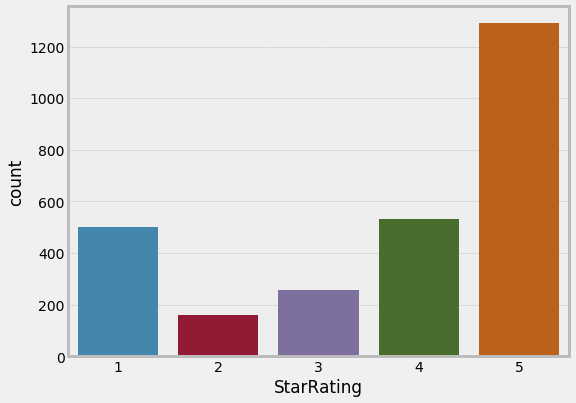

In [216]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.style.use('bmh')
sns.countplot(x='StarRating', data=df)

As shown above, this data is imbalanced.

## 2. Cleaning reviews from stop words

#### Removing all the stop words and punctuations from dataset and creating corpus which contains stem of the words. 

In [15]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
import nltk


def Stop_word(df):
    corpus = []
    for row in df.T.iteritems(): 
        row = ' '.join(map(str,row))
        review = re.sub('[^A-Za-z0-9]',' ', row)
        review = re.sub (',', ' ', review)
        review = re.sub (';',' ', review)
        review = re.sub ('"',' ', review)
        review = re.sub ('Unname',' ', review)
        review = review.lower()
        review = review.split()
        ps = PorterStemmer()
        stop_words = set(stopwords.words('english'))
        stop_words.update(['null' , 'name' , 'dtype','object',
                           'rebtel','unname','starrating','unname', 'body',
                           'nan','title', '1', '0'])
        review = [ps.stem(word) for word in review if not word in stop_words]
        review = ' '.join(review)
        corpus.append(review)
    return corpus

### Visualizing the most frequent words in the reviews:

Select 1 (very bad), or 2 (bad),or 3 (neutral), or 4 (good),or 5 (very good) star reviews?1
How many most common words to print: 10

OK. The 10 most frequent words are as follows

(u'call', ': ', 155)
(u'servic', ': ', 141)
(u'use', ': ', 96)
(u'custom', ': ', 85)
(u'worst', ': ', 60)
(u'bad', ': ', 56)
(u'charg', ': ', 51)
(u'compani', ': ', 44)
('app', ': ', 43)
(u'make', ': ', 37)


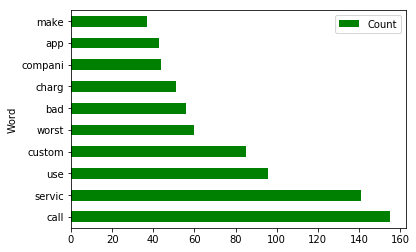

In [16]:
import collections
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def word_counter(df):
    # the most frequent words in bad reviews with 1 star
    rate_print = int(input("Select 1 (very bad), or 2 (bad),or 3 (neutral), or 4 (good),or 5 (very good) star reviews?"))
    df_review = df[df.StarRating == rate_print]
    NewDf = df_review[['Title','Body']].copy()  
    corpus_bad = Stop_word(NewDf)
    wordcount = {}
    for item in corpus_bad: 
        for word in item.lower().split():
            if word not in wordcount:
                wordcount[word] = 1
            else:
                wordcount[word] += 1
    # Print the most common words please note that the root of words are extracted
    n_print = int(input("How many most common words to print: "))
    print("\nOK. The {} most frequent words are as follows\n".format(n_print))
    word_counter = collections.Counter(wordcount)
    for word, count in word_counter.most_common(n_print):
        print(word, ": ", count)
    # Create a data frame of the most common words 
    # Draw a bar chart
    lst = word_counter.most_common(n_print)
    df_counter = pd.DataFrame(lst, columns = ['Word', 'Count'])
    df_counter.plot.barh(x='Word',y='Count', color = 'green')
 
word_counter(df)  

## 3. Classification
### 3.1. classificaiton without up or down-sampling.

Choosing our classifier and Grid search over hyper parameters

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from time import time
from sklearn.metrics import accuracy_score, confusion_matrix, accuracy_score,classification_report


def HyperParamGS(X_train,y_train):
    pipeline = Pipeline([
               ('vect', CountVectorizer(ngram_range=(1,3)) ),
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier(max_iter=1000, tol = 0)),
                ])

    parameters = {
              'vect__max_df': (0.5, 0.75, 1.0),
              'vect__ngram_range': [(1,1), (1,2)],
              #'tfidf__norm': ('l1', 'l2', None),
              'tfidf__use_idf': (True, False),
              'clf__loss': ('log','modified_huber','hinge'),
              'clf__penalty':('l2','elasticnet'),
              'clf__alpha': (0.00001, 0.000001),
              'clf__class_weight': (None, 'balanced'),
             }

    gs_clf = GridSearchCV(estimator=pipeline, param_grid=parameters, 
                          n_jobs=-1, verbose=1, cv = 5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time()
    gs_clf.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()
    return gs_clf, parameters

def model_result(gs_clf, X_test, y_test, parameters):
    print("Best score: %0.3f" % gs_clf.best_score_)
    print("Best parameters set:")
    best_parameters = gs_clf.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))    
    #### Cross-validation to check the test set error rate
    scores = cross_val_score(gs_clf, X_train, y_train, scoring='neg_mean_absolute_error')
    print(scores)
    ## Predicting the test set results
    y_pred = gs_clf.predict(X_test)
    print("The accuracy score of {0}".format(accuracy_score(y_test, y_pred)))
    print ('Confusion Matrix:')
    # Confustion matrix
    print (confusion_matrix(y_test, y_pred))
    print (accuracy_score(y_test, y_pred))
    # Classification report with precision and recall
    print (classification_report(y_test, y_pred))
    return y_pred



Combining the title and body of reviews and spliting the data into training and test set

In [17]:
NewDf = df[['Title','Body']].copy()
X = Stop_word(NewDf)
y = df.iloc[:,1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)

In [418]:
trained_model, parameters = HyperParamGS(X_train,y_train)
y_pred = model_result(trained_model, X_test, y_test, parameters)

Performing grid search...
('pipeline:', ['vect', 'tfidf', 'clf'])
parameters:
{'vect__ngram_range': [(1, 1), (1, 2)], 'vect__max_df': (0.5, 0.75, 1.0), 'clf__loss': ('log', 'modified_huber', 'hinge'), 'tfidf__use_idf': (True, False), 'clf__penalty': ('l2', 'elasticnet'), 'clf__class_weight': (None, 'balanced'), 'clf__alpha': (1e-05, 1e-06)}
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   56.5s finished


done in 56.893s
()
Best score: 0.582
Best parameters set:
	clf__alpha: 1e-05
	clf__class_weight: None
	clf__loss: 'log'
	clf__penalty: 'elasticnet'
	tfidf__use_idf: True
	vect__max_df: 0.75
	vect__ngram_range: (1, 2)
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 356 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 856 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   39.7s finished


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   39.4s finished


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 372 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 872 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   39.2s finished


[-0.77 -0.75 -0.73]
The accuracy score of 0.60097323601
Confusion Matrix:
[[108   7   8   8  31]
 [ 20   4   3   3  16]
 [ 10   0  13  22  32]
 [  9   3   5  35 102]
 [  8   1   4  36 334]]
0.60097323601
             precision    recall  f1-score   support

          1       0.70      0.67      0.68       162
          2       0.27      0.09      0.13        46
          3       0.39      0.17      0.24        77
          4       0.34      0.23      0.27       154
          5       0.65      0.87      0.74       383

avg / total       0.55      0.60      0.56       822



#### Confusion matrix

Confusion matrix, without normalization
[[108   7   8   8  31]
 [ 20   4   3   3  16]
 [ 10   0  13  22  32]
 [  9   3   5  35 102]
 [  8   1   4  36 334]]


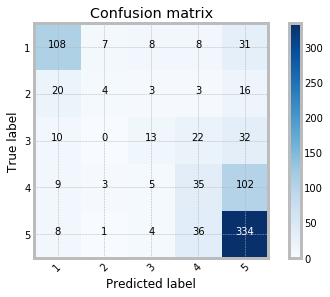

In [421]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= ['1','2','3','4','5'],
                      title='Confusion matrix')

plt.show()

### 3.2. Classification with up-sampling:
I will use the balanced data to train my model then I will use the imbalanced data to test my model.

#### Up sampling with SMOTE and Random over-sampling.
imblanaced-learn is available via:
pip install -U imbalanced-learn or
conda install -c glemaitre imbalanced-learn


In [7]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from imblearn import pipeline as pl
from imblearn import over_sampling as os


def HyperParamGSOV(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)
    #ros = os.SMOTE(random_state=0)
    ros = RandomOverSampler(random_state = 0)
    pipeline = Pipeline([
               ('vect', CountVectorizer(ngram_range=(1,3)) ),
               ('tfidf', TfidfTransformer()),
               ('OvSam', ros),
               ('clf', SGDClassifier(max_iter=1000, tol = 0)),
                ])

    parameters = {
              'vect__max_df': (0.5, 0.75, 1.0),
              'vect__ngram_range': [(1,1), (1,2)],
              #'tfidf__norm': ('l1', 'l2', None),
              'tfidf__use_idf': (True, False),
              'clf__loss': ('log','modified_huber','hinge'),
              'clf__penalty':('l2','elasticnet'),
              'clf__alpha': (0.00001, 0.000001),
              'clf__class_weight': (None, 'balanced'),
             }

    gs_clf = GridSearchCV(estimator=pipeline, param_grid=parameters, 
                          n_jobs=-1, verbose=1, cv = 5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time()
    gs_clf.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()
    print("Best score: %0.3f" % gs_clf.best_score_)
    print("Best parameters set:")
    best_parameters = gs_clf.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))    
        #### Cross-validation to check the test set error rate
    scores = cross_val_score(gs_clf, X_train, y_train, scoring='neg_mean_absolute_error')
    print(scores)
    ## Predicting the test set results
    y_pred = gs_clf.predict(X_test)
    
    print("The accuracy score of {0}".format(accuracy_score(y_test, y_pred)))
    print ('Confusion Matrix:')
    print (confusion_matrix(y_test, y_pred))
    print (accuracy_score(y_test, y_pred))
    print (classification_report(y_test, y_pred))
    
    return y_test, y_pred


In [465]:
X = Stop_word(NewDf)
y = df.iloc[:,1].values
y_ov_test, y_ov_pred = HyperParamGSOV(X,y)

Performing grid search...
('pipeline:', ['vect', 'tfidf', 'OvSam', 'clf'])
parameters:
{'vect__ngram_range': [(1, 1), (1, 2)], 'vect__max_df': (0.5, 0.75, 1.0), 'clf__loss': ('log', 'modified_huber', 'hinge'), 'tfidf__use_idf': (True, False), 'clf__penalty': ('l2', 'elasticnet'), 'clf__class_weight': (None, 'balanced'), 'clf__alpha': (1e-05, 1e-06)}
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  1.1min finished


done in 64.990s
()
Best score: 0.584
Best parameters set:
	clf__alpha: 1e-05
	clf__class_weight: 'balanced'
	clf__loss: 'modified_huber'
	clf__penalty: 'elasticnet'
	tfidf__use_idf: False
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   50.1s finished


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 860 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   45.7s finished


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 860 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   45.6s finished


[-0.76 -0.77 -0.78]
The accuracy score of 0.599756690998
Confusion Matrix:
[[109   5   6  11  31]
 [ 22   3   3   2  16]
 [ 11   2  12  17  35]
 [  9   1   8  40  96]
 [ 13   0   6  35 329]]
0.599756690998
             precision    recall  f1-score   support

          1       0.66      0.67      0.67       162
          2       0.27      0.07      0.11        46
          3       0.34      0.16      0.21        77
          4       0.38      0.26      0.31       154
          5       0.65      0.86      0.74       383

avg / total       0.55      0.60      0.56       822



Confusion matrix, without normalization
[[114  11   8   8  21]
 [ 22   6   5   2  11]
 [ 12   2  19  19  25]
 [  7   6   5  45  91]
 [ 13   1   8  43 318]]


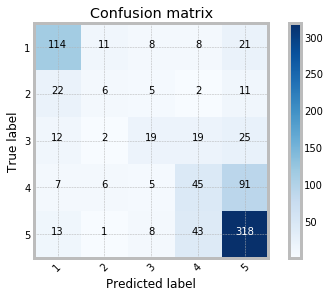

In [452]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_ov_test, y_ov_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= ['1','2','3','4','5'],
                      title='Confusion matrix')
plt.show()

### 3.2. Classificaiton with combination of up-down sampling with SMOTETomek


Grid search over hyper parameters with SMOTETomek

In [25]:
from imblearn.pipeline import Pipeline
def HyperParamSGD_sampled(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)
    smote = SMOTETomek(random_state = 0)
    #smote = SMOTEENN(random_state = 0)
    pipeline = Pipeline([
               ('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('smote', smote),
               ('clf', SGDClassifier(max_iter=1000, tol = 0)),
                ])

    parameters = {
              'vect__max_df': (0.5, 0.75, 1.0),
              'vect__ngram_range': [(1,1), (1,2)],
              #'tfidf__norm': ('l1', 'l2', None),
              'tfidf__use_idf': (True, False),
              'clf__loss': ('log','modified_huber','hinge'),
              'clf__penalty':('l2','elasticnet'),
              'clf__alpha': (0.00001, 0.000001),
              'clf__class_weight': (None, 'balanced'),
             }

    gs_clf = GridSearchCV(estimator=pipeline, param_grid=parameters, 
                          n_jobs=-1, verbose=1, cv = 5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time()
    gs_clf.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % gs_clf.best_score_)
    print("Best parameters set:")
    best_parameters = gs_clf.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
        #### Cross-validation to check the test set error rate
    scores = cross_val_score(gs_clf, X_train, y_train, scoring='neg_mean_absolute_error')
    print(scores)
    
    
    ## Predicting the test set results
    y_pred = gs_clf.predict(X_test)
    
    print("The accuracy score of {0}".format(accuracy_score(y_test, y_pred)))
    print ('Confusion Matrix:')
    print (confusion_matrix(y_test, y_pred))
    print (accuracy_score(y_test, y_pred))
    print (classification_report(y_test, y_pred))
    return y_test, y_pred

In [230]:
X = Stop_word(NewDf)
y = df.iloc[:,1].values
y_smote_test, y_smote_pred = HyperParamSGD_sampled(X,y)

Performing grid search...
('pipeline:', ['vect', 'tfidf', 'smote', 'clf'])
parameters:
{'vect__ngram_range': [(1, 1), (1, 2)], 'vect__max_df': (0.5, 0.75, 1.0), 'clf__loss': ('log', 'modified_huber', 'hinge'), 'tfidf__use_idf': (True, False), 'clf__penalty': ('l2', 'elasticnet'), 'clf__class_weight': (None, 'balanced'), 'clf__alpha': (1e-05, 1e-06)}
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 13.6min finished


done in 821.451s
()
Best score: 0.581
Best parameters set:
	clf__alpha: 1e-05
	clf__class_weight: None
	clf__loss: 'log'
	clf__penalty: 'l2'
	tfidf__use_idf: True
	vect__max_df: 0.75
	vect__ngram_range: (1, 2)
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  8.5min finished


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  8.6min finished


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  8.6min finished


[-0.75 -0.84 -0.77]
The accuracy score of 0.605839416058
Confusion Matrix:
[[114  11   9   7  21]
 [ 23   6   5   3   9]
 [ 10   1  19  21  26]
 [  8   5   7  46  88]
 [ 15   2   7  46 313]]
0.605839416058
             precision    recall  f1-score   support

          1       0.67      0.70      0.69       162
          2       0.24      0.13      0.17        46
          3       0.40      0.25      0.31        77
          4       0.37      0.30      0.33       154
          5       0.68      0.82      0.75       383

avg / total       0.57      0.61      0.58       822



### Confusion matrix:
This function plots the confusion matrix:

In [29]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_uppred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes= ['1','2','3','4','5'],
                      title='Confusion matrix')

plt.show()

## 3.3. Classificaiton with review picking


### Aproach 1:
It depends on what stakeholders expect from this analysis. One can simply make a data set of 3 classes, like combining rate 1,2 reviews (as bad reviews), rate 3 (neutral), rate 4,5 (as good reviews). It helps partially to overcome imbalanced data.

In [343]:
df_updated_3 = df
df_updated_3['NewRating'] = df['StarRating'].replace([1,2,3,4,5],[1,1,2,3,3])
df_updated_3.head()

,Unnamed: 0,StarRating,Title,Body,NewRating
0,0,5,Rebtel makes it simple and easy to…,Rebtel makes it simple and easy to make calls...,3
1,1,5,Very good service,"Very good service. Cheap calls, good quality s...",3
2,2,2,Ive used this app for a few months but…,Ive used this app for a few months but then mo...,1
3,3,5,Cheap calls to My Mum in Malta,I am using this service to ring my mum in Malt...,3
4,4,5,God price and a god sound.,God price and a god sound.,3


The new distribution of classes.

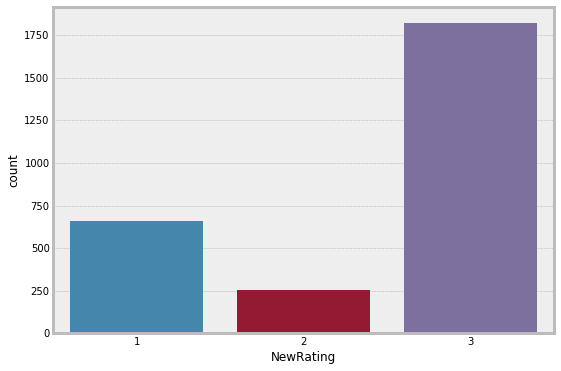

In [337]:
Newdf_updated_3 = df_updated_3[['Title','Body']].copy()
X_updated_3 = Stop_word(Newdf_updated_3)
y_updated_3 = df_updated_3.iloc[:,-1].values
plt.figure(figsize=(8, 6))
plt.style.use('bmh')
sns.countplot(x='NewRating', data=df_updated_3)

With combination of up-down sampling with SMOTETomek

In [305]:
y_test_up3, y_pred_up3 = HyperParamSGD_sampled(X_updated_3,y_updated_3)

Performing grid search...
('pipeline:', ['vect', 'tfidf', 'smote', 'clf'])
parameters:
{'vect__ngram_range': [(1, 1), (1, 2)], 'vect__max_df': (0.5, 0.75, 1.0), 'clf__loss': ('log', 'modified_huber', 'hinge'), 'tfidf__use_idf': (True, False), 'clf__penalty': ('l2', 'elasticnet'), 'clf__class_weight': (None, 'balanced'), 'clf__alpha': (1e-05, 1e-06)}
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 10.0min finished


done in 602.147s
()
Best score: 0.807
Best parameters set:
	clf__alpha: 1e-05
	clf__class_weight: 'balanced'
	clf__loss: 'hinge'
	clf__penalty: 'l2'
	tfidf__use_idf: True
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  6.4min finished


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  6.4min finished


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  6.4min finished


[-0.29 -0.31 -0.31]
The accuracy score of 0.805352798054
Confusion Matrix:
[[150   8  50]
 [ 15  12  50]
 [ 27  10 500]]
0.805352798054
             precision    recall  f1-score   support

          1       0.78      0.72      0.75       208
          2       0.40      0.16      0.22        77
          3       0.83      0.93      0.88       537

avg / total       0.78      0.81      0.79       822



#### Confusion matrix

Confusion matrix, without normalization
[[150   8  50]
 [ 15  12  50]
 [ 27  10 500]]


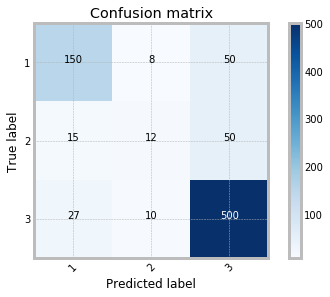

In [454]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_up3, y_pred_up3)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes= ['1','2','3'],
                      title='Confusion matrix')

plt.show()

####  Down-sampling with TomekLinks

#### Grid search over hyper parameters with down-sampled data

In [457]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from imblearn import pipeline as pl
from imblearn import over_sampling as os
from imblearn.under_sampling import TomekLinks


def HyperParamGSUN(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)
    ros = TomekLinks()
    pipeline = Pipeline([
               ('vect', CountVectorizer(ngram_range=(1,3)) ),
               ('tfidf', TfidfTransformer()),
               ('OvSam', ros),
               ('clf', SGDClassifier(max_iter=1000, tol = 0)),
                ])

    parameters = {
              'vect__max_df': (0.5, 0.75, 1.0),
              'vect__ngram_range': [(1,1), (1,2)],
              #'tfidf__norm': ('l1', 'l2', None),
              'tfidf__use_idf': (True, False),
              'clf__loss': ('log','modified_huber','hinge'),
              'clf__penalty':('l2','elasticnet'),
              'clf__alpha': (0.00001, 0.000001),
              'clf__class_weight': (None, 'balanced'),
             }

    gs_clf = GridSearchCV(estimator=pipeline, param_grid=parameters, 
                          n_jobs=-1, verbose=1, cv = 5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time()
    gs_clf.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()
    print("Best score: %0.3f" % gs_clf.best_score_)
    print("Best parameters set:")
    best_parameters = gs_clf.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))    
        #### Cross-validation to check the test set error rate
    scores = cross_val_score(gs_clf, X_train, y_train, scoring='neg_mean_absolute_error')
    print(scores)
    ## Predicting the test set results
    y_pred = gs_clf.predict(X_test)
    
    print("The accuracy score of {0}".format(accuracy_score(y_test, y_pred)))
    print ('Confusion Matrix:')
    print (confusion_matrix(y_test, y_pred))
    print (accuracy_score(y_test, y_pred))
    print (classification_report(y_test, y_pred))
    
    return y_test, y_pred


In [458]:
Newdf_updated_3 = df_updated_3[['Title','Body']].copy()
X_updated_3 = Stop_word(Newdf_updated_3)
y_updated_3 = df_updated_3.iloc[:,-1].values
y_un_test, y_un_pred = HyperParamGSUN(X_updated_3,y_updated_3)


Performing grid search...
('pipeline:', ['vect', 'tfidf', 'OvSam', 'clf'])
parameters:
{'vect__ngram_range': [(1, 1), (1, 2)], 'vect__max_df': (0.5, 0.75, 1.0), 'clf__loss': ('log', 'modified_huber', 'hinge'), 'tfidf__use_idf': (True, False), 'clf__penalty': ('l2', 'elasticnet'), 'clf__class_weight': (None, 'balanced'), 'clf__alpha': (1e-05, 1e-06)}
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  1.2min finished


done in 72.278s
()
Best score: 0.805
Best parameters set:
	clf__alpha: 1e-05
	clf__class_weight: None
	clf__loss: 'log'
	clf__penalty: 'elasticnet'
	tfidf__use_idf: False
	vect__max_df: 1.0
	vect__ngram_range: (1, 1)
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   48.8s finished


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 868 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   48.1s finished


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 356 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 856 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   47.8s finished


[-0.3  -0.33 -0.34]
The accuracy score of 0.800486618005
Confusion Matrix:
[[149   8  51]
 [ 19   8  50]
 [ 31   5 501]]
0.800486618005
             precision    recall  f1-score   support

          1       0.75      0.72      0.73       208
          2       0.38      0.10      0.16        77
          3       0.83      0.93      0.88       537

avg / total       0.77      0.80      0.78       822



Confusion matrix, without normalization
[[149   8  51]
 [ 19   8  50]
 [ 31   5 501]]


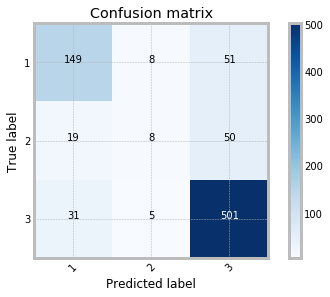

In [459]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_un_test, y_un_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes= ['1','2','3'],
                      title='Confusion matrix')
plt.show()

### Aproach 2:
Sometimes it is important to know what are bad or good reviews. therefore, one can simply disregard rate 3 in reviews (as it is neutral), then combine rate 1,2 reviews (as bad reviews) and 4,5 reviews ( as good reviews).

In [20]:
df_updated = df.loc[df['StarRating'] != 3]
df_updated['NewRating'] = df_updated['StarRating'].apply(lambda x: 1 if x > 3 else 0)
df_updated.head()

C:\Users\51648\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Unnamed: 0,StarRating,Title,Body,NewRating
0,0,5,Rebtel makes it simple and easy to…,Rebtel makes it simple and easy to make calls...,1
1,1,5,Very good service,"Very good service. Cheap calls, good quality s...",1
2,2,2,Ive used this app for a few months but…,Ive used this app for a few months but then mo...,0
3,3,5,Cheap calls to My Mum in Malta,I am using this service to ring my mum in Malt...,1
4,4,5,God price and a god sound.,God price and a god sound.,1


The new distribution of data with mentioned changes:

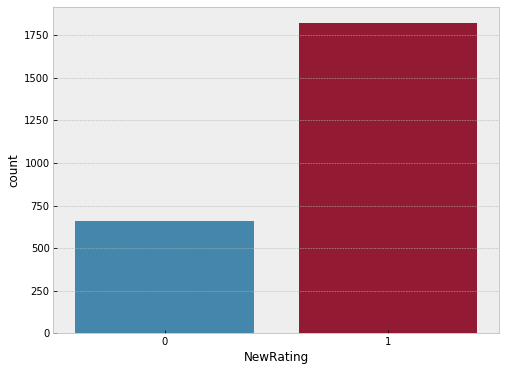

In [22]:
import seaborn as sns
NewDf_updated = df_updated[['Title','Body']].copy()
X_updated = Stop_word(NewDf_updated)
y_updated = df_updated.iloc[:,-1].values
plt.figure(figsize=(8, 6))
plt.style.use('bmh')
sns.countplot(x='NewRating', data=df_updated)

Training the model with balanced data (SMOTETomek) and testing with imbalanced data

In [26]:
y_test_up, y_pred_up = HyperParamSGD_sampled(X_updated,y_updated)

Performing grid search...
('pipeline:', ['vect', 'tfidf', 'smote', 'clf'])
parameters:
{'vect__ngram_range': [(1, 1), (1, 2)], 'vect__max_df': (0.5, 0.75, 1.0), 'clf__loss': ('log', 'modified_huber', 'hinge'), 'tfidf__use_idf': (True, False), 'clf__penalty': ('l2', 'elasticnet'), 'clf__class_weight': (None, 'balanced'), 'clf__alpha': (1e-05, 1e-06)}
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  8.9min finished


done in 534.625s
()
Best score: 0.896
Best parameters set:
	clf__alpha: 1e-05
	clf__class_weight: 'balanced'
	clf__loss: 'log'
	clf__penalty: 'l2'
	tfidf__use_idf: False
	vect__max_df: 1.0
	vect__ngram_range: (1, 2)
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  5.3min finished


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  5.0min finished


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  5.8min finished


[-0.11896552 -0.0984456  -0.11226252]
The accuracy score of 0.881879194631
Confusion Matrix:
[[151  46]
 [ 42 506]]
0.8818791946308725
             precision    recall  f1-score   support

          0       0.78      0.77      0.77       197
          1       0.92      0.92      0.92       548

avg / total       0.88      0.88      0.88       745



Confusion matrix, without normalization
[[151  46]
 [ 42 506]]


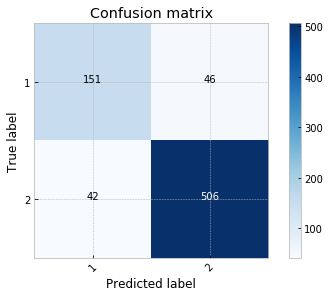

In [30]:
# Compute confusion matrix
import numpy as np
cnf_matrix = confusion_matrix(y_test_up, y_pred_up)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes= ['1','2'],
                      title='Confusion matrix')
plt.show()

#### Confusion matrix

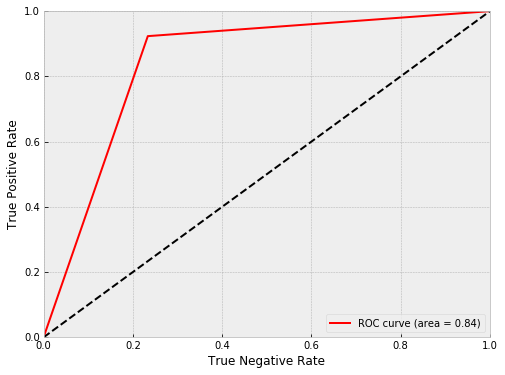

In [31]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test_up, y_pred_up)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
lw = 2
plt.plot(fpr, tpr, color='red', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('True Negative Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()




Since the data is imbalanced, it is better to change the metric to g-mean

In [32]:
from imblearn.metrics import (geometric_mean_score,
                              make_index_balanced_accuracy)
print('The geometric mean is {}'.format(geometric_mean_score(
    y_test_up, y_pred_up)))

The geometric mean is 0.841279564763
